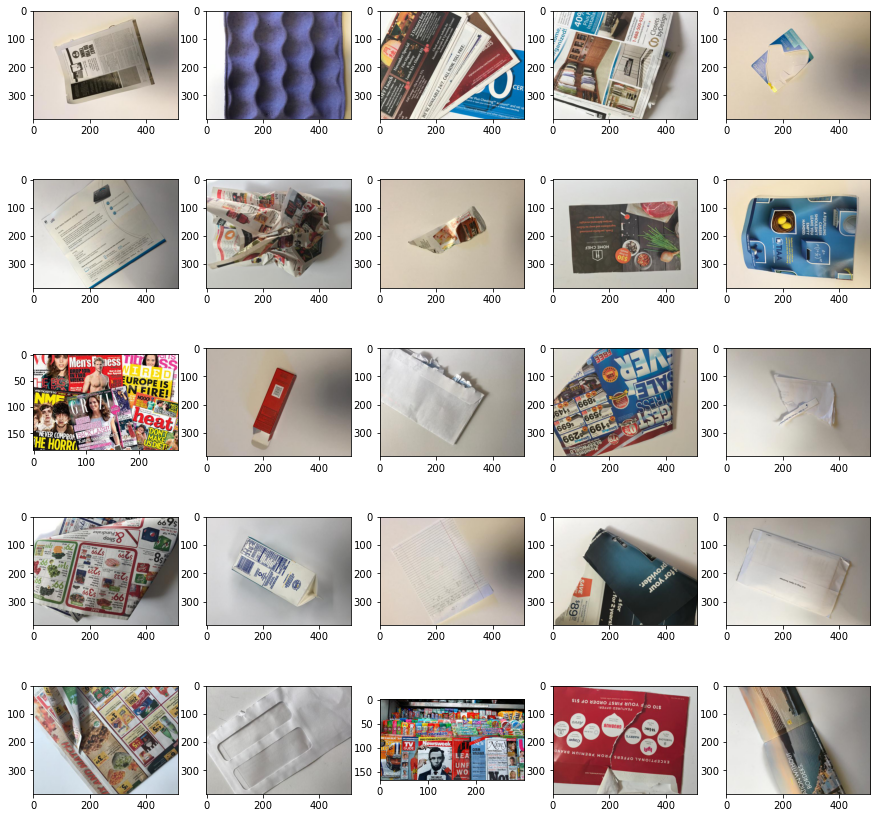

In [3]:
#Mostrar algunas imagenes con pyplot
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(15,15))

carpeta = 'datasets/dataset 3/paper'
imagenes = os.listdir(carpeta)

for i, nombreimg in enumerate(imagenes[:25]):
  plt.subplot(5,5,i+1)
  imagen = mpimg.imread(carpeta + '/' + nombreimg)
  plt.imshow(imagen)

Found 12451 images belonging to 5 classes.
Found 3110 images belonging to 5 classes.


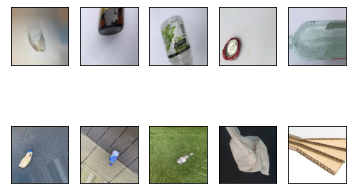

In [10]:
#Aumento de datos con ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

#Crear el dataset generador
datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 30,
    width_shift_range = 0.25,
    height_shift_range = 0.25,
    shear_range = 15,
    validation_split=0.2 #20% para pruebas
)

#Generadores para sets de entrenamiento y pruebas
data_gen_entrenamiento = datagen.flow_from_directory('datasets/dataset 3', target_size=(224,224),
                                                     batch_size=32, shuffle=True, subset='training')
data_gen_pruebas = datagen.flow_from_directory('datasets/dataset 3', target_size=(224,224),
                                                     batch_size=32, shuffle=True, subset='validation')

#Imprimir 10 imagenes del generador de entrenamiento
for imagen, etiqueta in data_gen_entrenamiento:
  for i in range(10):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(imagen[i])
  break
plt.show()

In [11]:
import tensorflow as tf
import tensorflow_hub as hub

url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
mobilenetv2 = hub.KerasLayer(url, input_shape=(224,224,3))

mobilenetv2.trainable = False

In [12]:
modelo = tf.keras.Sequential([
    mobilenetv2,
    tf.keras.layers.Dense(5, activation='softmax')
])

In [13]:
modelo.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [14]:
#Entrenar el modelo
EPOCAS = 50

historial = modelo.fit(
    data_gen_entrenamiento, epochs=EPOCAS, batch_size=32,
    validation_data=data_gen_pruebas
)



Epoch 1/50
390/390 [==============================] - 574s 1s/step - loss: 0.6419 - accuracy: 0.7542 - val_loss: 0.7473 - val_accuracy: 0.7164
Epoch 2/50
390/390 [==============================] - 489s 1s/step - loss: 0.4155 - accuracy: 0.8441 - val_loss: 0.6686 - val_accuracy: 0.7556
Epoch 3/50
390/390 [==============================] - 491s 1s/step - loss: 0.3747 - accuracy: 0.8627 - val_loss: 0.6286 - val_accuracy: 0.7656
Epoch 4/50
390/390 [==============================] - 490s 1s/step - loss: 0.3392 - accuracy: 0.8749 - val_loss: 0.6296 - val_accuracy: 0.7740
Epoch 5/50
390/390 [==============================] - 490s 1s/step - loss: 0.3296 - accuracy: 0.8811 - val_loss: 0.6276 - val_accuracy: 0.7778
Epoch 6/50
390/390 [==============================] - 487s 1s/step - loss: 0.3112 - accuracy: 0.8881 - val_loss: 0.6457 - val_accuracy: 0.7833
Epoch 7/50
390/390 [==============================] - 491s 1s/step - loss: 0.3028 - accuracy: 0.8872 - val_loss: 0.6213 - val_accuracy: 0.7878

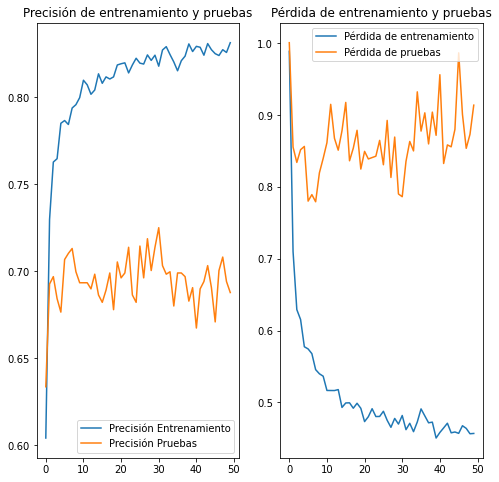

In [7]:
#Graficas de precisión
acc = historial.history['accuracy']
val_acc = historial.history['val_accuracy']

loss = historial.history['loss']
val_loss = historial.history['val_loss']

rango_epocas = range(50)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(rango_epocas, acc, label='Precisión Entrenamiento')
plt.plot(rango_epocas, val_acc, label='Precisión Pruebas')
plt.legend(loc='lower right')
plt.title('Precisión de entrenamiento y pruebas')

plt.subplot(1,2,2)
plt.plot(rango_epocas, loss, label='Pérdida de entrenamiento')
plt.plot(rango_epocas, val_loss, label='Pérdida de pruebas')
plt.legend(loc='upper right')
plt.title('Pérdida de entrenamiento y pruebas')
plt.show()

In [8]:
from PIL import Image
import requests
from io import BytesIO
import cv2

def categorizar(url):
  respuesta = requests.get(url)
  img = Image.open(BytesIO(respuesta.content))
  img = np.array(img).astype(float)/255

  img = cv2.resize(img, (224,224))
  prediccion = modelo.predict(img.reshape(-1, 224, 224, 3)) 
  for x in prediccion[0]:
        x = round(x,5)
        print(str(x))
  return np.argmax(prediccion[0], axis=-1)

def categorizar2(path):
    img = Image.open(path)
    img = np.array(img).astype(float)/255
    img = cv2.resize(img, (224,224))
    prediccion = modelo.predict(img.reshape(-1, 224, 224, 3))
    for x in prediccion[0]:
        x = '{:0.3e}'.format(x)
        print(str(x))
    return np.argmax(prediccion[0], axis=-1)

def mostrarCategoria(nombre):
    print("nombre")
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(image, 'Carton', (10,450), font, 3, (0, 255, 0), 2, cv2.LINE_AA)
    cv2.imshow(window_name,image)

In [9]:
#0 = carton, 1 = vidrio, 2 = metal ,3 = papel , 4 plastico
url = 'https://img2.rtve.es/a/5897383/?h=320'
prediccion = categorizar (url)
print(prediccion)

0.00044
0.0204
0.00043
0.0
0.97874
4


In [10]:
import os


datos = 'capturas'
if not os.path.exists(datos):
    print('Carpeta creada: ',datos)
    os.makedirs(datos)

modelo.save('saved_model/my_model2')

INFO:tensorflow:Assets written to: saved_model/my_model2\assets


INFO:tensorflow:Assets written to: saved_model/my_model2\assets


In [1]:
import numpy as np


count = 0 #para contar las capturas
capture = cv2.VideoCapture(0)
while (capture.isOpened()):
    k = cv2.waitKey(1);
    ret, frame = capture.read()
    cv2.imshow('webCam',frame)
    if (k == ord('s')):  #s para cerrar 
        break
    elif (k == ord('c')): #c para sacar captura
        cv2.imwrite(datos+'/objeto_{}.jpg'.format(count),frame)
        print('Imagen guardada:'+'/objeto_{}.jpg'.format(count))
        
        ##captura
        path = datos+'/objeto_{}.jpg'.format(count)
        resultado = categorizar2(path)
        print (resultado)
        image = cv2.imread(path)
        window_name = 'image'
        if resultado == 0:
            print("Carton")
            font = cv2.FONT_HERSHEY_SIMPLEX
            cv2.putText(image, 'Carton', (10,450), font, 3, (0, 255, 0), 2, cv2.LINE_AA)
            cv2.imshow(window_name,image)
        elif resultado == 1:
            print("Vidrio")
            font = cv2.FONT_HERSHEY_SIMPLEX
            cv2.putText(image, 'Vidrio', (10,450), font, 3, (0, 255, 0), 2, cv2.LINE_AA)
            cv2.imshow(window_name,image)
        elif resultado == 2:
            print("metal")
            font = cv2.FONT_HERSHEY_SIMPLEX
            cv2.putText(image, 'Metal', (10,450), font, 3, (0, 255, 0), 2, cv2.LINE_AA)
            cv2.imshow(window_name,image)
        elif resultado == 3:
            print("papel")
            font = cv2.FONT_HERSHEY_SIMPLEX
            cv2.putText(image, 'Papel', (10,450), font, 3, (0, 255, 0), 2, cv2.LINE_AA)
            cv2.imshow(window_name,image)
        elif resultado == 4:
            print("plastico")
            font = cv2.FONT_HERSHEY_SIMPLEX
            cv2.putText(image, 'Plastico', (10,450), font, 3, (0, 255, 0), 2, cv2.LINE_AA)
            cv2.imshow(window_name,image)
        count+=1
        
        


capture.release()
cv2.destroyAllWindows()


NameError: name 'cv2' is not defined